In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from itertools import product

data = pd.read_csv('c_data.csv')
report = pd.read_csv('updated_report.csv')
agency = pd.read_csv('gov_entities.csv')
report_selected = report[['report_uuid', 'amount']]
agency_map = dict(sorted(agency.drop_duplicates(['government_entity_id', 'government_entity_name']).set_index('government_entity_id')['government_entity_name'].items()))

In [2]:
data.rename(columns={"report_uuid": "uuid"}, inplace=True)
agency.rename(columns={"filing_uuid": "uuid"}, inplace=True)
new_data = data[data['filing_year'] >= 2008]
new_data = new_data[~new_data['filing_period_code'].isin(['H1', 'H2'])]

In [3]:
lobby_duration = new_data.groupby('lob_id')['filing_year'].apply(lambda x: x.nunique()).reset_index()
lobby_duration.columns = ['lob_id', 'lobbying_duration']

mean_duration = lobby_duration['lobbying_duration'].mean()
median_duration = lobby_duration['lobbying_duration'].median()
print("Mean lobbying duration:", mean_duration)
print("Median lobbying duration:", median_duration)

Mean lobbying duration: 5.013992776087142
Median lobbying duration: 3.0


In [7]:
temp_list = lobby_duration[lobby_duration['lobbying_duration'] >= 14]['lob_id'].tolist()
temp_data = new_data[new_data['lob_id'].isin(temp_list)]

filtered_controls = filter_issue(temp_data, "telecommunications")
filtered_controls.loc[:, 'amount'] = filtered_controls['amount'].fillna(0)

In [8]:
companies = [
    'SAMSUNG ELECTRONICS AMERICA, INC.',
    'LENOVO (UNITED STATES) INC.',
    #'SAP AMERICA, INC.',
    #'TYCO ELECTRONICS',
    'BROADCOM INC.',
    'ERICSSON INC.',
    #'EXPERIAN NORTH AMERICA',
    #'NEWS CORPORATION',
    'T-MOBILE USA, INC.',
    #'RELX INC.',
    #'THOMSON REUTERS',
    #'ASTELLAS PHARMA US, INC.',
    'INTELSAT',
    #'TRANSAMERICA COMPANIES',
    #'MAXAR TECHNOLOGIES',
    'BT AMERICAS INC',
    #'DAIMLER/MERCEDES-BENZ USA',
    'PANASONIC CORPORATION OF NORTH AMERICA',
    #'RESEARCH IN MOTION',
    'ORANGE BROADBAND HOLDING COMPANY/BAJA BROADBAND',
    #'TRACFONE WIRELESS, INC.',
    'ZENITH ELECTRONICS CORP'
]
# Remove companies (according to criteria set in paper)

In [9]:
controls = new_data[new_data['client_name'].isin(companies)]
controls_deduplicated = controls.drop_duplicates(subset=['uuid'])
controls_aggregated = controls_deduplicated.groupby(['client_name', 'filing_year', 'filing_period_code'], as_index=False)['amount'].sum()
controls_aggregated['time'] = controls_aggregated['filing_year'].astype(str) + '-' + controls_aggregated['filing_period_code']
controls_aggregated = controls_aggregated[controls_aggregated['time'] >= '2008-Q4']
controls_aggregated.to_csv('controls.csv')

## Graphs

In [6]:
def filter_client_names(dataframe, word):
    return dataframe[dataframe['client_name'].str.contains(word, case=False, na=False)]

In [5]:
def filter_issue(dataframe, word):
    return dataframe[dataframe['issue_text'].str.contains(word, case=False, na=False)]

In [10]:
huawei = filter_client_names(new_data, "huawei")
huawei.loc[:, 'amount'] = huawei['amount'].fillna(0)

In [11]:
huawei_deduplicated = huawei.drop_duplicates(subset=['uuid'])
huawei_deduplicated['time'] = huawei_deduplicated['filing_year'].astype(str) + '-' + huawei_deduplicated['filing_period_code']
before_2019Q3 = huawei_deduplicated[huawei_deduplicated['time'] < '2019-Q3']
after_2019Q3 = huawei_deduplicated[huawei_deduplicated['time'] >= '2019-Q3']

/var/folders/10/2rvf3sm517d767znb2p0rt6m0000gn/T/ipykernel_14336/1771401344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  huawei_deduplicated['time'] = huawei_deduplicated['filing_year'].astype(str) + '-' + huawei_deduplicated['filing_period_code']


In [ ]:
huawei_aggregated = huawei_deduplicated.groupby(['filing_year', 'filing_period_code'], as_index=False)['amount'].sum()
huawei_aggregated['time'] = huawei_aggregated['filing_year'].astype(str) + '-' + huawei_aggregated['filing_period_code']

if "2010-Q1" not in huawei_aggregated['time'].values:
    missing_row = pd.DataFrame({
        'filing_year': [2010],
        'filing_period_code': ['Q1'],
        'amount': [0.0],
        'time': ['2010-Q1']
    })
    huawei_aggregated = pd.concat([huawei_aggregated, missing_row], ignore_index=True)

huawei_aggregated = huawei_aggregated.sort_values(by='time').reset_index(drop=True)
huawei_aggregated.to_csv('huawei.csv')

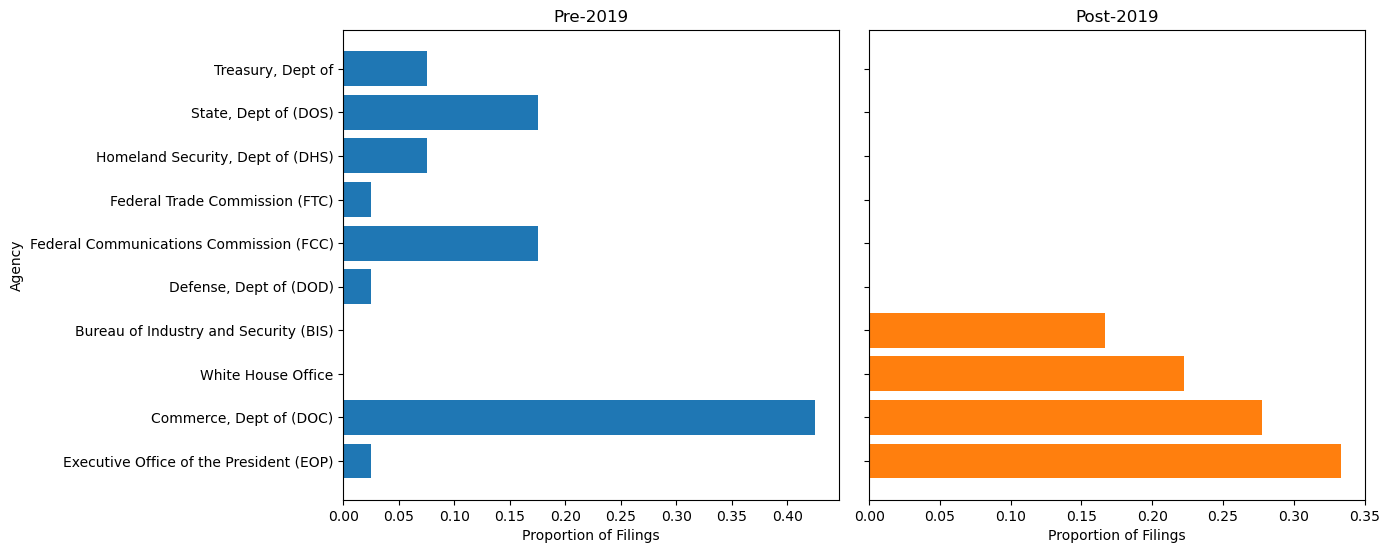

In [ ]:
huawei_agency = pd.merge(huawei_deduplicated, agency, on='uuid', how='left')

agency_map = dict(
    agency.drop_duplicates(['government_entity_id', 'government_entity_name'])
          .set_index('government_entity_id')['government_entity_name']
)
huawei_agency['agency_name'] = huawei_agency['government_entity_id'].map(agency_map)

agency_counts = (
    huawei_agency.groupby(['filing_year', 'agency_name'])['uuid']
    .nunique()
    .reset_index(name='num_filings')
)

agency_counts['period'] = agency_counts['filing_year'].apply(lambda x: 'Pre-2019' if x < 2019 else 'Post-2019')

summary = (
    agency_counts[~agency_counts['agency_name'].isin(['HOUSE OF REPRESENTATIVES', 'SENATE'])]
    .groupby(['agency_name', 'period'])['num_filings']
    .sum()
    .unstack(fill_value=0)
    .sort_values('Post-2019', ascending=False)
)

pre = summary['Pre-2019'] / summary['Pre-2019'].sum()
post = summary['Post-2019'] / summary['Post-2019'].sum()

proportion_df = pd.DataFrame({'Pre-2019': pre, 'Post-2019': post})
agency_order = proportion_df.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].barh(agency_order, proportion_df['Pre-2019'].loc[agency_order], color='#1f77b4')
axes[0].set_title("Pre-2019")
axes[0].set_xlabel("Proportion of Filings")
axes[0].set_ylabel("Agency")
axes[1].barh(agency_order, proportion_df['Post-2019'].loc[agency_order], color='#ff7f0e')
axes[1].set_title("Post-2019")
axes[1].set_xlabel("Proportion of Filings")
axes[1].set_yticks(range(len(agency_order)))
axes[1].set_yticklabels(agency_order)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
before_grouped = (
    before_2019Q3.groupby('issue_text', as_index=False)
    .size()
    .rename(columns={'size': 'count_before'})
    .sort_values(by='count_before', ascending=False)
    .head(5)
)

after_grouped = (
    after_2019Q3.groupby('issue_text', as_index=False)
    .size()
    .rename(columns={'size': 'count_after'})
    .sort_values(by='count_after', ascending=False)
    .head(5)
)

print("Top 5 Issue Texts Before 2019Q3:")
for i, row in before_grouped.iterrows():
    print(f"{i + 1}. {row['issue_text']} (Count: {row['count_before']})")

print("\nTop 5 Issue Texts After 2019Q3:")
for i, row in after_grouped.iterrows():
    print(f"{i + 1}. {row['issue_text']} (Count: {row['count_after']})")

Top 5 Issue Texts Before 2019Q3:
5. Foreign investment and security-related issues. (Count: 13)
37. Technology; telecommunications networks and products; cybersecurity (Count: 9)
44. Telecommunications equipment, cyber security (Count: 8)
8. Foreign investment and security-related issues. Contact with the U.S.-China Economic and Security Review Commission. (Count: 6)
4. Foreign investment and security-related issues (Count: 5)

Top 5 Issue Texts After 2019Q3:
2. Export controls, trade and economic sanctions, and other national security-related topics (Count: 15)
13. Telecommunications and trade issues. (Count: 7)
5. Foreign investment, government purchasing, and security-related issues arising under the National Defense Authorization Act and in connection with issues at the Federal Communications Commission, Office of the US Trade Representative and the White House. (Count: 6)
16. Telecommunications, export controls, and trade and economic sanctions, including HR 2500, The National Def

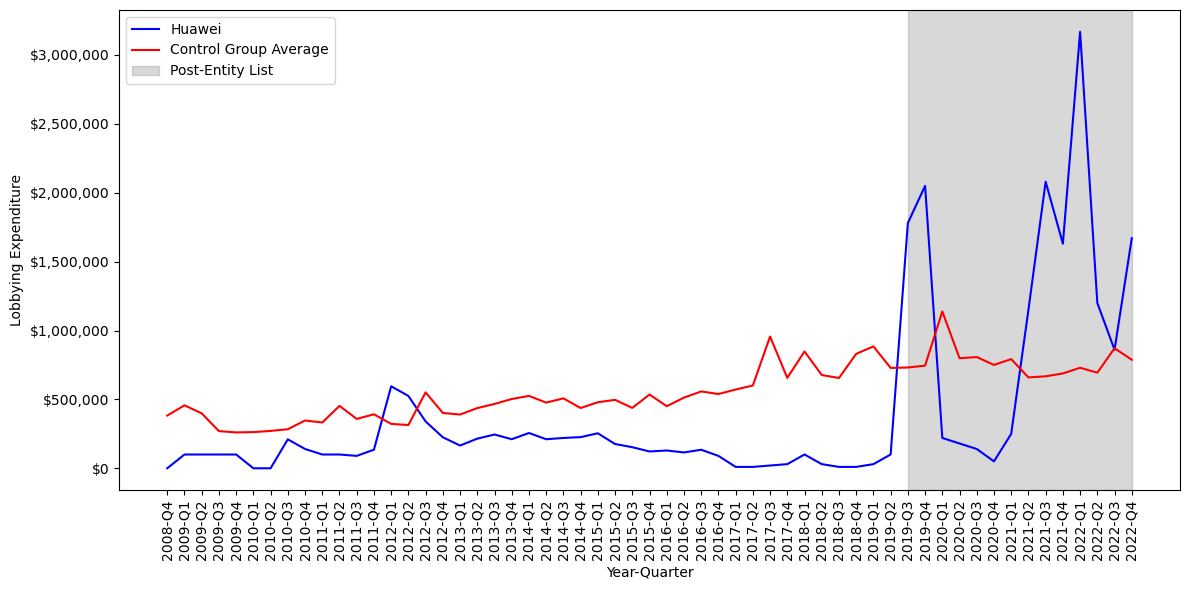

In [ ]:
controls_average = controls_aggregated.groupby('time')['amount'].mean().reset_index()
controls_average = controls_average.sort_values(by='time')
huawei_aggregated = huawei_aggregated.sort_values(by=['filing_year', 'filing_period_code'])

post_sanction_start = '2019-Q3'
post_sanction_end = '2022-Q4'

plt.figure(figsize=(12, 6))
plt.plot(huawei_aggregated['time'], huawei_aggregated['amount'], linestyle='-', color = 'blue', label='Huawei')
plt.plot(controls_average['time'], controls_average['amount'], linestyle='-', color='red', label='Control Group Average')

plt.axvspan(post_sanction_start, post_sanction_end, color='gray', alpha=0.3, label='Post-Entity List')
plt.xticks(rotation=90)
plt.xlabel('Year-Quarter')
plt.ylabel('Lobbying Expenditure')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.legend()
plt.tight_layout()

plt.show()

In [90]:
zte = filter_client_names(new_data, "ZTE CORPORATION")
alibaba = filter_client_names(new_data, "ALIBABA GROUP HOLDING LIMITED")
bytedance = filter_client_names(new_data, "BYTEDANCE INC.")
xiaomi = filter_client_names(new_data, "BEIJING XIAOMI MOBILE SOFTWARE CO., LTD.")
tencent = filter_client_names(new_data, "TENCENT AMERICA LLC")
byd = filter_client_names(new_data, "BYD NORTH AMERICA")
huawei = filter_client_names(new_data, "HUAWEI TECHNOLOGIES CO., LTD.")

In [ ]:
years = range(2008, 2023)
quarters = ['Q1','Q2','Q3','Q4']
full = [f"{y}-{q}" for y,q in product(years,quarters)]
time_index = full[full.index('2008-Q4'): full.index('2022-Q4')+1]

def standardize(df):
    df = df.drop_duplicates('uuid').copy()
    df['amount'] = df['amount'].fillna(0)
    df['time']   = df['filing_year'].astype(str) + '-' + df['filing_period_code']
    s = df.groupby('time')['amount'].sum()
    return s.reindex(time_index, fill_value=0)

huawei_s = standardize(huawei).replace(0, np.nan)
zte_s = standardize(zte).replace(0, np.nan)
alibaba_s = standardize(alibaba).replace(0, np.nan)
bytedance_s = standardize(bytedance).replace(0, np.nan)
byd_s = standardize(byd).replace(0, np.nan)
xiaomi_s   = standardize(xiaomi).replace(0, np.nan)
tencent_s  = standardize(tencent).replace(0, np.nan)

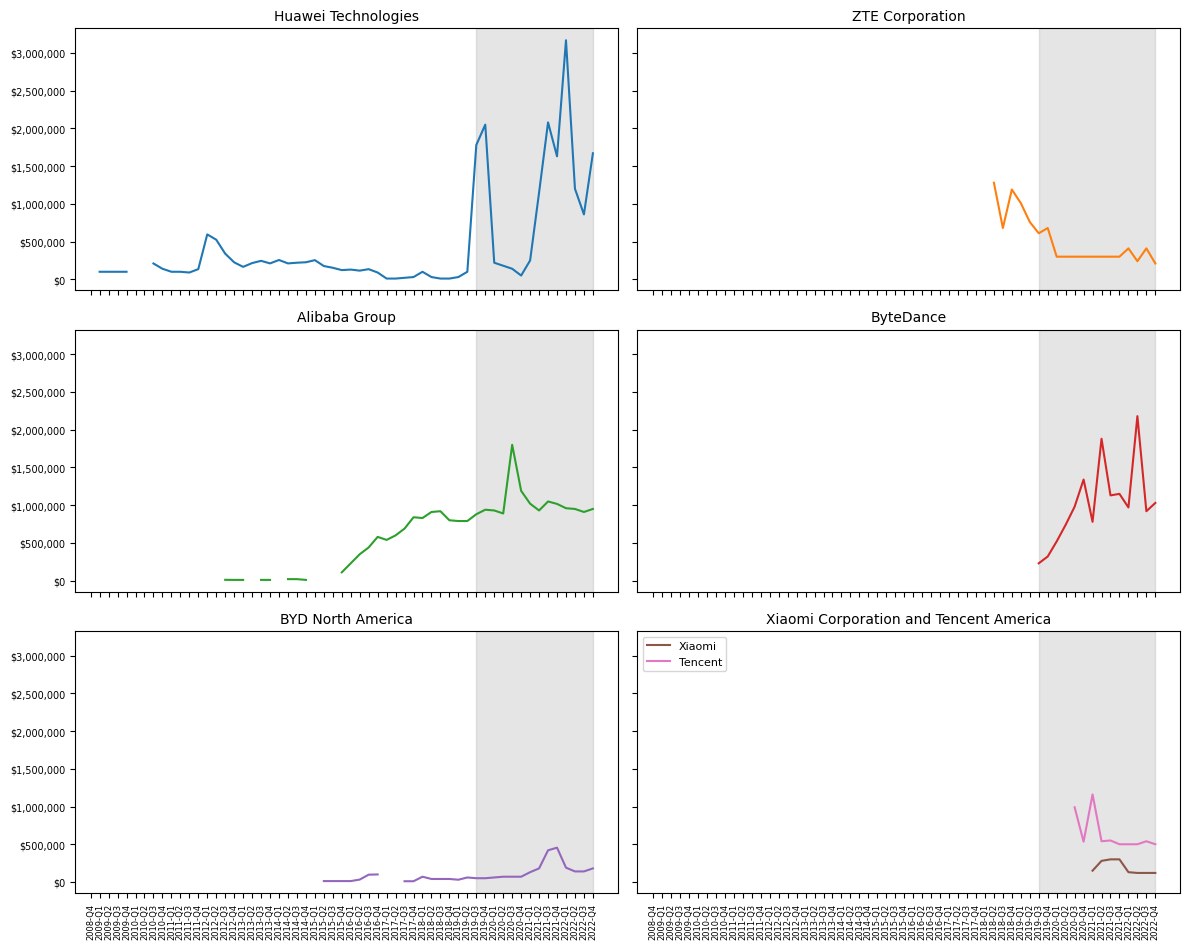

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(12,10), sharex=True, sharey=True)
axes = axes.flatten()
colors = plt.cm.tab10.colors

panels = [
    ('Huawei Technologies', huawei_s),
    ('ZTE Corporation', zte_s),
    ('Alibaba Group', alibaba_s),
    ('ByteDance', bytedance_s),
    ('BYD North America', byd_s)
]
for i,(name, s) in enumerate(panels):
    ax = axes[i]
    s_plot = s.replace(0, np.nan)
    ax.plot(time_index, s_plot, color=colors[i], lw=1.5)
    ax.axvspan('2019-Q3', '2022-Q4', color='gray', alpha=0.2)
    ax.set_title(name, fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=6)
    ax.tick_params(axis='y', labelsize=7)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):,}'))

ax = axes[5]
ax.plot(time_index, xiaomi_s, label='Xiaomi',  color=colors[5], lw=1.5)
ax.plot(time_index, tencent_s, label='Tencent', color=colors[6], lw=1.5)
ax.axvspan('2019-Q3', '2022-Q4', color='gray', alpha=0.2)
ax.set_title('Xiaomi Corporation and Tencent America', fontsize=10)
ax.tick_params(axis='x', rotation=90, labelsize=6)
ax.legend(fontsize=8, loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):,}'))
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()